The daily mean air temperature exhibits a sinusoidal pattern due to the Earth's axial tilt and its orbit around the Sun. During the year, as the Earth orbits the Sun, the angle at which sunlight hits the Earth changes, leading to warmer temperatures when the sun is more directly overhead and cooler temperatures when it is at a lower angle. The smooth transition between these temperature extremes follows a wave-like, or sinusoidal, pattern, peaking during summer  and troughing in winter, with transitions through spring and fall.

As a result, a sinusoidal model can be used to represent this pattern as a function of the calendar day of the year, incorporating the annual mean temperature, mean annual thermal amplitude, and a phase constant corresponding to the timing of the minimum temperature. Mathematically, this model can be expressed as:

$$ T(d) = T_{avg} + A \; cos \Bigg[2 \pi \Bigg(\frac{d-d_{min}}{365} \Bigg) + \phi \Bigg] $$

where:
- $T(d)$ is the predicted temperature on day of the year \( d \),
- $T_{avg}$ is the annual mean temperature,
- $A$ is the mean annual thermal amplitude (half the difference between the maximum and minimum air temperatures),
- $d$ is the day of the year,
- $d_{min}$ is an offset day of the year corresponding to the minimum temperature, and
- $\phi$ is the phase shift needed to align the model with the observed data, in this case $\pi$ . 

This sinusoidal model captures the regular, predictable changes in temperature due to the Earth's position relative to the Sun.

In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean


## Basics of waves

In [4]:
doy = np.arange(1, 366)
wave_model = lambda x,a,b,c: a + b * np.cos(2*np.pi*(x-c)/365 + np.pi)


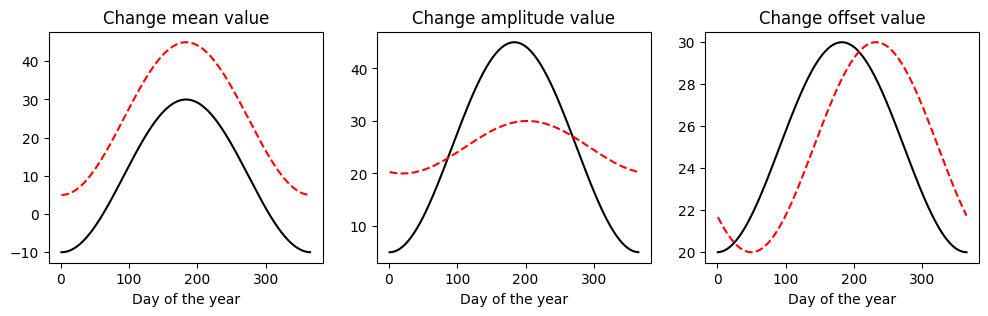

In [24]:
doy = np.arange(1,366,1)

plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
plt.title('Change mean value')
plt.plot(doy, wave_model(doy, a=10, b=20, c=1), '-k')
plt.plot(doy, wave_model(doy, a=25, b=20, c=1), '--r')
plt.xlabel('Day of the year')

plt.subplot(1,3,2)
plt.title('Change amplitude value')
plt.plot(doy, wave_model(doy, a=25, b=20, c=1), '-k')
plt.plot(doy, wave_model(doy, a=25, b=5, c=20), '--r')
plt.xlabel('Day of the year')

plt.subplot(1,3,3)
plt.title('Change offset value')
plt.plot(doy, wave_model(doy, a=25, b=5, c=0), '-k')
plt.plot(doy, wave_model(doy, a=25, b=5, c=50), '--r')
plt.xlabel('Day of the year')

plt.show()


## Load and inspect data

In [64]:
# Read dataset
df = pd.read_csv('../datasets/KS_Manhattan_6_SSW.csv',
                 parse_dates=['LST_DATE'], date_format='%Y%m%d', na_values=[-9999,-99])

# Retain columns of interest
df = df[['LST_DATE','T_DAILY_AVG']]

# Add year and day of the year columns
df['DOY'] = df['LST_DATE'].dt.dayofyear
df['YEAR'] = df['LST_DATE'].dt.year

# Inspect a few rows
df.head(3)


,LST_DATE,T_DAILY_AVG,DOY,YEAR
0,2003-10-01,NaN,274,2003
1,2003-10-02,11.7,275,2003
2,2003-10-03,14.8,276,2003


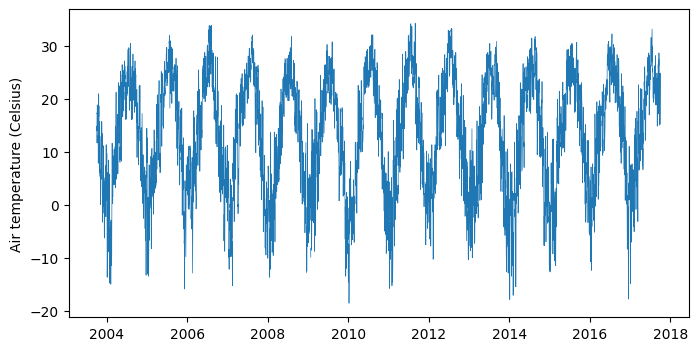

In [65]:
# Inspect complete air temperature data to see seasonal pattern
plt.figure(figsize=(8,4))
plt.plot(df['LST_DATE'], df['T_DAILY_AVG'], linewidth=0.5)
plt.ylabel('Air temperature (Celsius)')
plt.show()


## Split dataset into training and testing sets

In this tutorial we are using the train set to estimate the model parameters. We then make predictions of average air temperature using these parameters in both the train and test sets.

In [66]:
# Split set into training and test
N = round(df.shape[0]*0.75)
df_train = df[:N]
df_test = df[N+1:].reset_index(drop=True)


## Define model for air temperature


In [67]:
# Daily air temperature model
model = lambda doy,a,b,c: a + b * np.cos(2*np.pi*( (doy-c)/365) + np.pi)


## Estimate model parameters from data

In [68]:
# Annual mean temperature
T_avg = df['T_DAILY_AVG'].mean()
print(f'Mean annual temperature: {T_avg:.2f}')


Mean annual temperature: 13.09


In [69]:
# Annual mean thermal amplitude
T_min,T_max = df_train.groupby(by='DOY')["T_DAILY_AVG"].mean().quantile([0.05,0.95])
A = (T_max - T_min)/2
print(f'Mean annual thermal amplitude: {A:.2f}')


Mean annual thermal amplitude: 14.36


In [76]:
# Timing of minimum air temperature
idx_min = df_train.groupby(by='YEAR')['T_DAILY_AVG'].idxmin()
doy_T_min = np.round(df_train.loc[idx_min,'DOY'].apply(circmean).mean())
print(f'DOY of minimum temperature (phase constant): {doy_T_min}')


DOY of minimum temperature (phase constant): 3.0


## Predict air temperature for training set

In [77]:
# Predict daily T with model
T_pred_train = model(df_train['DOY'], T_avg, A, doy_T_min)


In [78]:
# Compute mean absolute error on train set
mae_train = np.mean(np.abs(df_train['T_DAILY_AVG'] - T_pred_train)) 

print(f'MAE on train set: {mae_train:.2f} Celsius')

MAE on train set: 4.53 Celsius


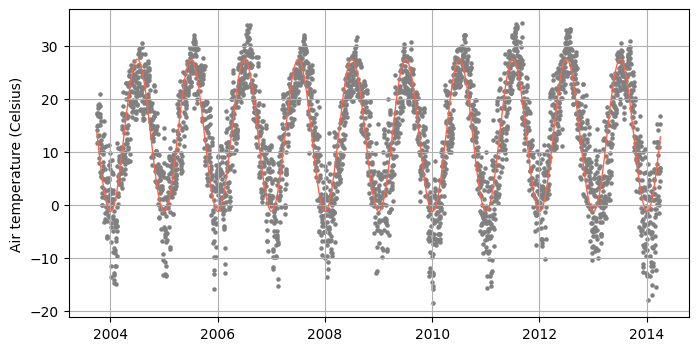

In [79]:
# Create figure
plt.figure(figsize=(8,4))
plt.scatter(df_train["LST_DATE"], df_train["T_DAILY_AVG"], s=5, color='gray', label="Observed")
plt.plot(df_train["LST_DATE"],T_pred_train, label="Predicted", color='tomato', linewidth=1)
plt.ylabel("Air temperature (Celsius)")
plt.grid()
plt.show()


## Predict daily average air temperature for test set

In this step we use the same parameters determined using the training set.

In [80]:
# Predict daily T with model
T_pred_test = model(df_test['DOY'], T_avg, A, doy_T_min)


In [81]:
# Compute mean absolute error on test set
mae_test = np.mean(np.abs(df_test['T_DAILY_AVG'] - T_pred_test)) 

print(f'MAE on test set: {mae_test:.2f} Celsius')

MAE on test set: 4.54 Celsius


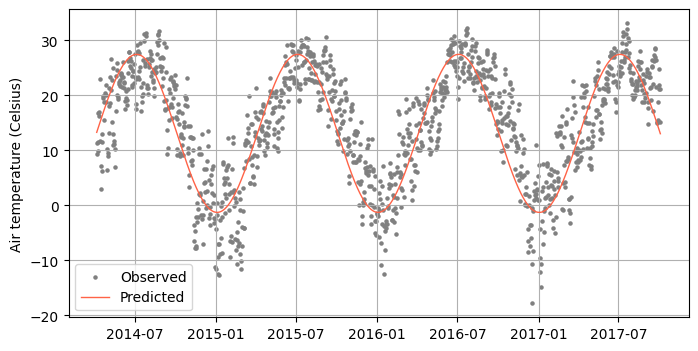

In [82]:
# Create figure
plt.figure(figsize=(8,4))
plt.scatter(df_test["LST_DATE"], df_test["T_DAILY_AVG"], s=5, color='gray', label="Observed")
plt.plot(df_test["LST_DATE"],T_pred_test, label="Predicted", color='tomato', linewidth=1)
plt.ylabel("Air temperature (Celsius)")
plt.grid()
plt.legend()
plt.show()


## Practice

- Use the `curve_fit()` function from SciPy to fit the model and compare parameters values with this exercise.

- Read a dataset of hourly observations of mean air temperature and fit a model with an additional harmonic to simulate diurnal thermal osciallations in addition to the seasonal oscillations.